#library

In [43]:
import os
import glob
import random
import tensorflow
import numpy as np
from sklearn import svm
from keras import layers
from keras import models
from skimage import feature
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.python import image
from keras.utils import to_categorical
# from keras_visualizer import visualizer 
from keras.layers.core.dense import Dense
from sklearn.metrics import accuracy_score
from keras.utils.vis_utils import plot_model
from tensorflow.python.ops.math_ops import add
from keras.engine.sequential import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.layers.serialization import activation
from tensorflow.python.ops.math_ops import Sigmoid
from sklearn.model_selection import train_test_split
from keras.layers.convolutional.base_separable_conv import activations
import cv2
from skimage.feature import local_binary_pattern

#Part1.compatness

In [44]:
def compatness(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  binary_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, 13)
  contours, hierarchy= cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  contour_max = sorted(contours, key=cv2.contourArea)[-1]
  compactness_score = (4 * np.pi * cv2.contourArea(contour_max)) / (cv2.arcLength(contour_max, True) ** 2)
  return np.array(compactness_score)


#Part2.eccenticity

In [45]:
def eccenticity(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  binary_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, 13)
  contours, hierarchy= cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  contour_max = sorted(contours, key=cv2.contourArea)[-1]
  (x, y), (min, max), a = cv2.fitEllipse(contour_max)
  eccentricity_score = (1 - ((min / max) ** 2))**0.5
  return np.array(eccentricity_score)

#Part3.solidity

In [46]:
def solidity(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  binary_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, 13)
  contours, hierarchy= cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  contour_max = sorted(contours, key=cv2.contourArea)[-1]
  solidity_score = float(cv2.contourArea(contour_max))/cv2.contourArea(cv2.convexHull(contour_max))
  return  np.array(solidity_score)

#Part4.LBP

In [47]:
def histogram_of_LBP(image, numPoints, radius, eps=1e-7):
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	lbp = local_binary_pattern(image, numPoints, radius, method='uniform')
	n_bins = int(lbp.max() + 1)
	hist_values = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))[0]
	return hist_values

#validate function

In [48]:
def validating_func(image_ship_path, image_airplane_path):
  ship_img = cv2.imread(image_ship_path)
  airplane_img = cv2.imread(image_airplane_path)
  eccenticity_ship, eccenticity_airplane = eccenticity(ship_img), eccenticity(airplane_img)
  compatness_ship, compatness_airplane = compatness(ship_img), compatness(airplane_img)
  solidity_ship, solidity_airplane = solidity(ship_img), solidity(airplane_img)
  print(f"Result for ship image:\ncompatness is : {compatness_ship}\t\teccenticity is : {eccenticity_ship}\t\tsolidity is : {solidity_ship}")
  print(f"Result for airplane image:\ncompatness is : {compatness_airplane}\t\teccenticity is : {eccenticity_airplane}\t\tsolidity is : {solidity_airplane}")
  

#Part5.prepare dataset(just run this cell and not change)

In [68]:
!gdown --id 1O_VkcGlWRR6h00VT8nXIgeI3RyvBpXbE
!unzip dataset.zip
classes = os.listdir("/content/dataset")
images_paths = glob.glob("/content/dataset/*/*")

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1O_VkcGlWRR6h00VT8nXIgeI3RyvBpXbE
To: /content/dataset.zip
100% 18.4M/18.4M [00:00<00:00, 232MB/s]
Archive:  dataset.zip
replace dataset/airplane/airplane1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset/airplane/airplane1.jpg  
  inflating: dataset/airplane/airplane136.jpg  
  inflating: dataset/airplane/airplane14.jpg  
  inflating: dataset/airplane/airplane141.jpg  
  inflating: dataset/airplane/airplane153.jpg  
  inflating: dataset/airplane/airplane156.jpg  
  inflating: dataset/airplane/airplane157.jpg  
  inflating: dataset/airplane/airplane159.jpg  
  inflating: dataset/airplane/airplane169.jpg  
  inflating: dataset/airplane/airplane170.jpg  
  inflating: dataset/airplane/airplane182.jpg  
  infla

In [69]:
x_data , y_data = [], []
for img_path in images_paths:
  x_data.append(cv2.resize(cv2.imread(img_path), (224,224)))
  if img_path.split("/")[3] == "ship":
    y_data.append(0)
  else:
    y_data.append(1)  

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,test_size = 0.2, shuffle= True)

#Part6. Exctract features and determine classifier

In [74]:
def get_featureMatrix(data):
  feature_matrix = [np.concatenate((compatness(d), eccenticity(d), solidity(d), histogram_of_LBP(d, 8, 2)), axis=None) for d in data]
  return feature_matrix

In [75]:
# model 1
feature_matrix_train = get_featureMatrix(x_train)
#determine classifier and train 
clf = svm.SVC()
clf.fit(feature_matrix_train, y_train)

SVC()

#Part7

In [76]:
#test on test dataset
feature_matrix_test = get_featureMatrix(x_test)
accuracy_score(y_test, clf.predict(feature_matrix_test))

0.75

#Part8

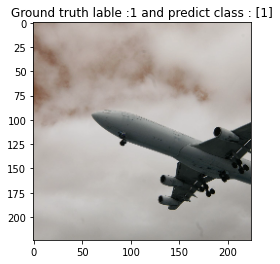

In [55]:
#test visualize
index = random.randint(0, len(x_test)-1)
prediction = clf.predict(get_featureMatrix(np.array([x_test[index]])))
plt.title(f"Ground truth lable :{y_test[index]} and predict class : {prediction}")
plt.imshow(x_test[index])
plt.show()